In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datasets import load_from_disk, load_dataset, concatenate_datasets, DatasetDict
import torchmetrics
from tqdm import tqdm
import numpy as np
import random
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os # Added for path joining
from IPython.lib.display import Audio as AudioDisplay

/home/pierre/Documents/Projects/PST4/AI/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# -----------------------------
# 2. Configuration & Setup
# -----------------------------
SEED = 42
BATCH_SIZE = 32
NUM_WORKERS = 24
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 4e-4
MODEL_SAVE_PATH = "./models_resnet.pt"
EPOCHS=20
sampling_rate = 16000
# --- Set Seeds for Reproducibility ---
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

print(f"Using device: {DEVICE}")
print(f"Number of workers: {NUM_WORKERS}")

Using device: cuda
Number of workers: 24


In [4]:
dataset = load_from_disk("../../dataset/ds_1_melspecto_noaug_balanced_chunked.hf")
dataset = dataset.with_format("torch", columns=["audio", "label"])

print("\nDataset splits:")
print({k: v.shape for k, v in dataset.items()})

print("\nDataset features:")
print(dataset["train"].features)


Dataset splits:
{'train': (352132, 2), 'val': (42198, 2), 'test': (44844, 2)}

Dataset features:
{'audio': List(List(List(Value('float64')))), 'label': ClassLabel(names=['other', 'drone'])}


In [5]:
def collate_fn_librosa(batch):
    inputs = []
    labels = []

    for item in batch:
        waveform = item["audio"]      # (8000,)
        label = item["label"]

        waveform = waveform.repeat(3, 1,1)

        inputs.append(waveform)
        labels.append(label)

    # Pad time dimension so all samples in batch have same T
    # (ResNet requires fixed size)
    inputs = torch.nn.utils.rnn.pad_sequence(
        inputs, batch_first=True
    )  # → [B, 3, 128, T_max]

    labels = torch.tensor(labels, dtype=torch.float32)

    return inputs, labels

train_loader = DataLoader(
    dataset["train"],
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn_librosa,
)

val_loader = DataLoader(
    dataset["val"],
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn_librosa,
)

test_loader = DataLoader(
    dataset["test"],
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn_librosa,
)

batch = next(iter(train_loader))
batch

(tensor([[[[ 1.4700,  1.5219,  1.2052,  ...,  1.5650,  1.1416,  0.9592],
           [ 0.7315,  0.9493,  1.0192,  ...,  1.7539,  1.1424,  0.9015],
           [ 0.7025,  0.9481,  1.2056,  ...,  1.3771,  1.1073,  0.7451],
           ...,
           [-1.1764, -0.7634, -0.8291,  ..., -1.2427, -1.0561, -1.2142],
           [-1.4888, -1.2547, -1.0688,  ..., -1.1143, -1.0442, -1.0809],
           [-1.6458, -1.1579, -1.0631,  ..., -1.3018, -1.2201, -1.2866]],
 
          [[ 1.4700,  1.5219,  1.2052,  ...,  1.5650,  1.1416,  0.9592],
           [ 0.7315,  0.9493,  1.0192,  ...,  1.7539,  1.1424,  0.9015],
           [ 0.7025,  0.9481,  1.2056,  ...,  1.3771,  1.1073,  0.7451],
           ...,
           [-1.1764, -0.7634, -0.8291,  ..., -1.2427, -1.0561, -1.2142],
           [-1.4888, -1.2547, -1.0688,  ..., -1.1143, -1.0442, -1.0809],
           [-1.6458, -1.1579, -1.0631,  ..., -1.3018, -1.2201, -1.2866]],
 
          [[ 1.4700,  1.5219,  1.2052,  ...,  1.5650,  1.1416,  0.9592],
           [ 

In [6]:
from torchvision import models

model = models.resnet50(weights=None)

# Replace final FC for binary classification
model.fc = nn.Linear(model.fc.in_features, 1)

model = model.to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


In [7]:
print(f"Loading best model from {MODEL_SAVE_PATH}...")
model = model.to(DEVICE)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
model.eval()
print("Loaded best model and set to eval mode.")

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        logits = model(x)
        probs = torch.sigmoid(logits)  # Convert logits to probabilities
        preds = (probs > 0.5).float()  # Apply 0.5 threshold for predictions

        all_preds.extend(preds.cpu().numpy().flatten())
        all_probs.extend(probs.cpu().numpy().flatten())
        all_labels.extend(y.cpu().numpy().flatten())

print("\nTest evaluation complete.")

Loading best model from ./models_resnet.pt...
Loaded best model and set to eval mode.


Testing: 100%|██████████| 1402/1402 [00:09<00:00, 142.57it/s]


Test evaluation complete.



Test Accuracy: 98.76%

Classification Report:
              precision    recall  f1-score   support

       other      0.982     0.993     0.988     22422
       drone      0.993     0.982     0.988     22422

    accuracy                          0.988     44844
   macro avg      0.988     0.988     0.988     44844
weighted avg      0.988     0.988     0.988     44844



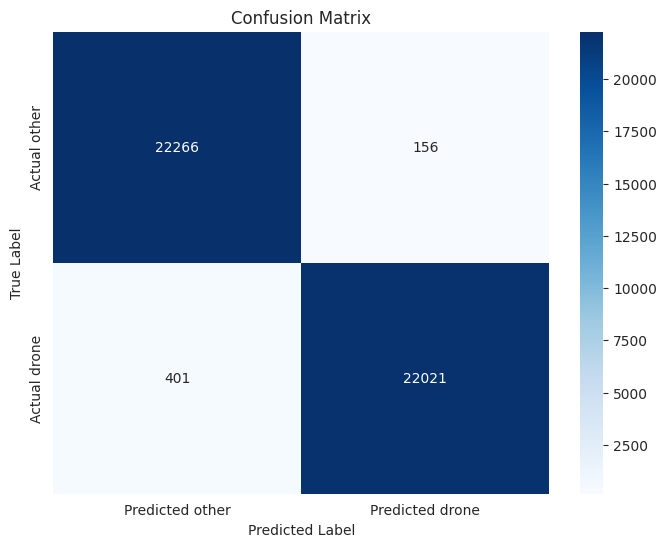


Results DataFrame head:
   true_label  pred_label  confidence
0         0.0         0.0    0.002682
1         0.0         0.0    0.167011
2         0.0         0.0    0.000006
3         0.0         0.0    0.007013
4         1.0         1.0    0.999988


In [8]:
# -----------------------------
# 11. Analyze Test Results
# -----------------------------
# --- Overall Accuracy ---
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")

# --- Classification Report ---
# Assuming 0 is 'fake' and 1 is 'real', or 'Class 0' and 'Class 1'
# Adjust target_names if you have the actual class names
try:
    # Try to get names from dataset features if they exist
    target_names = dataset["train"].features["label"].names
    if len(target_names) != 2: # Fallback if it's not binary
        target_names = ["Class 0", "Class 1"]
except:
    target_names = ["Class 0", "Class 1"]

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names, digits=3))

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Predicted {target_names[0]}", f"Predicted {target_names[1]}"],
            yticklabels=[f"Actual {target_names[0]}", f"Actual {target_names[1]}"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- Store results in a DataFrame (optional) ---
df_results = pd.DataFrame({
    "true_label": all_labels,
    "pred_label": all_preds,
    "confidence": all_probs
})

print("\nResults DataFrame head:")
print(df_results.head())

In [9]:
ds_test_online = load_dataset("Usernameeeeee/drone_test", split="test")
ds_test_online2 = load_dataset("Usernameeeeee/drone_test_2", split="test")

def swap_labels(example):
    example["label"] = 1 - example["label"]   # flips 0 ↔ 1
    return example

ds_test_online = ds_test_online.map(swap_labels)
ds_test_online2 = ds_test_online2.map(swap_labels)

In [10]:
import librosa
def convert_to_mel_spectrogram(data):
    mel = librosa.feature.melspectrogram(
        y=data,
        sr=sampling_rate,
        n_fft=1025,
        hop_length=256,
        n_mels=128,
        fmin=20,
        fmax=8000,
        power=2.0
    )
     # Convert to log scale (dB)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # Normalize
    mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-6)
    # Convert to torch tensor: [1, n_mels, time]
    mel_db = torch.tensor(mel_db).unsqueeze(0)

    return mel_db


def collate_fn_librosa_test(batch):
    inputs = []
    labels = []

    for item in batch:
        waveforme = item["audio"]["array"]
        wave = convert_to_mel_spectrogram(waveforme)
        wave = wave.repeat(3, 1, 1)
        inputs.append(wave)
        labels.append(item["label"])

    # Pad time dimension so all samples in batch have same T
    # (ResNet requires fixed size)
    inputs = torch.nn.utils.rnn.pad_sequence(
        inputs, batch_first=True
    )  # → [B, 3, 128, T_max]

    labels = torch.tensor(labels, dtype=torch.float32)

    return inputs, labels

In [11]:

test_loader_1 = DataLoader(
    ds_test_online,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn_librosa_test,
)
test_loader_2 = DataLoader(
    ds_test_online2,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn_librosa_test,
)


y_true1, y_pred1, y_true2, y_pred2 = [], [], [], []

with torch.no_grad():
    for x, y in tqdm(test_loader_1, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x).squeeze(1)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_pred1.extend(preds.cpu().numpy())
        y_true1.extend(y.cpu().numpy())

with torch.no_grad():
    for x, y in tqdm(test_loader_2, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x).squeeze(1)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_pred2.extend(preds.cpu().numpy())
        y_true2.extend(y.cpu().numpy())

Testing: 100%|██████████| 88/88 [00:05<00:00, 17.22it/s]


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except:
        auc = float("nan")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
        "confusion_matrix": cm,
    }

metrics1 = compute_metrics(y_true1, y_pred1)
metrics2 = compute_metrics(y_true2, y_pred2)

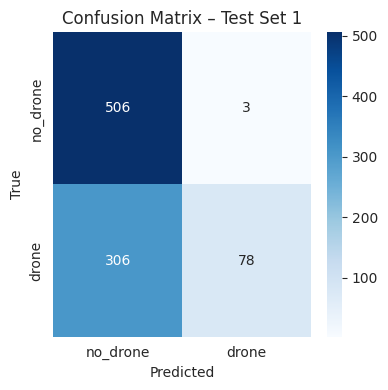

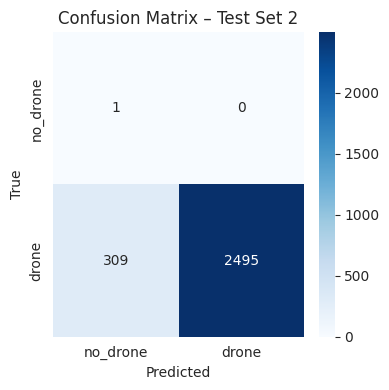

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = ["no_drone", "drone"]

def plot_confusion(cm, title):
    plt.figure(figsize=(4,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(metrics1["confusion_matrix"], "Confusion Matrix – Test Set 1")
plot_confusion(metrics2["confusion_matrix"], "Confusion Matrix – Test Set 2")

In [14]:
from datasets import Audio

local_folder_test_1 = "../../../data/test/mic_parabole"
ds_test_3 = load_dataset("audiofolder", data_dir=local_folder_test_1)["train"]

local_folder_test_2 = "../../../data/test/mic_bird_um1"
ds_test_4 = load_dataset("audiofolder", data_dir=local_folder_test_2)["train"]

local_folder_test_3 = "../../../data/test/parabole2"
ds_test_5 = load_dataset("audiofolder", data_dir=local_folder_test_3)["train"]

def swap_labels(example):
    example["label"] = 1 - example["label"]   # flips 0 ↔ 1
    return example

ds_test_3 = ds_test_3.cast_column("audio", Audio(sampling_rate=16000))
ds_test_3 = ds_test_3.map(swap_labels)
ds_test_4 = ds_test_4.cast_column("audio", Audio(sampling_rate=16000))
ds_test_4 = ds_test_4.map(swap_labels)
ds_test_5 = ds_test_5.cast_column("audio", Audio(sampling_rate=16000))
ds_test_5 = ds_test_5.map(swap_labels)

In [15]:
print(dataset["train"].features["label"].names[ds_test_5[0]["label"]])
AudioDisplay(ds_test_5[0]["audio"]["array"], rate=16000)

drone


In [16]:
test_loader_3 = DataLoader(
    ds_test_3,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn_librosa_test,
)
test_loader_4 = DataLoader(
    ds_test_4,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn_librosa_test,
)
test_loader_5 = DataLoader(
    ds_test_5,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn_librosa_test,
)

In [17]:
y_true1, y_pred1, y_true2, y_pred2, y_true3, y_pred3 = [], [], [], [], [], []

with torch.no_grad():
    for x, y in tqdm(test_loader_3, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x).squeeze(1)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_pred1.extend(preds.cpu().numpy())
        y_true1.extend(y.cpu().numpy())

with torch.no_grad():
    for x, y in tqdm(test_loader_4, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x).squeeze(1)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_pred2.extend(preds.cpu().numpy())
        y_true2.extend(y.cpu().numpy())

with torch.no_grad():
    for x, y in tqdm(test_loader_5, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x).squeeze(1)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_pred3.extend(preds.cpu().numpy())
        y_true3.extend(y.cpu().numpy())

Testing:  44%|████▍     | 22/50 [00:00<00:00, 31.91it/s]/home/pierre/Documents/Projects/PST4/AI/.venv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1025 is too large for input signal of length=480
  warnings.warn(
Testing: 100%|██████████| 85/85 [00:01<00:00, 73.10it/s]


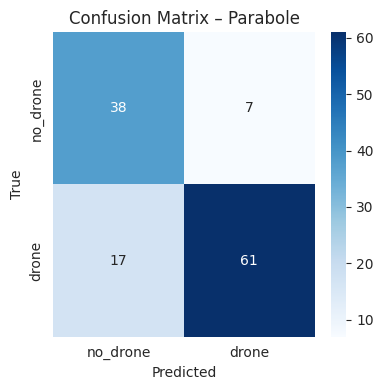

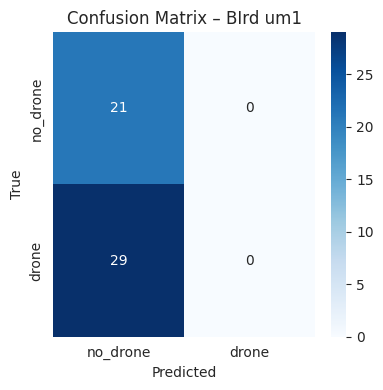

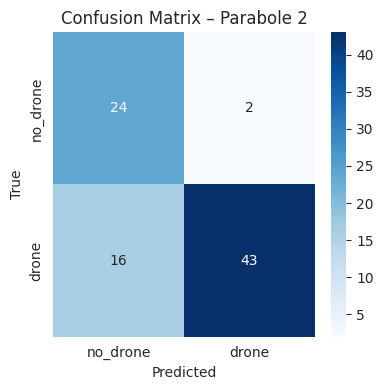

In [18]:
metrics1 = compute_metrics(y_true1, y_pred1)
metrics2 = compute_metrics(y_true2, y_pred2)
metrics3 = compute_metrics(y_true3, y_pred3)
plot_confusion(metrics1["confusion_matrix"], "Confusion Matrix – Parabole")
plot_confusion(metrics2["confusion_matrix"], "Confusion Matrix – BIrd um1")
plot_confusion(metrics3["confusion_matrix"], "Confusion Matrix – Parabole 2")


In [27]:
def infer_from_folder(folder_path: str):
    files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    results = []

    for file in files:
        file_path = os.path.join(folder_path, file)
        waveform, sr = librosa.load(file_path, sr=sampling_rate)
        mel_spec = convert_to_mel_spectrogram(waveform)
        mel_spec = mel_spec.repeat(3, 1, 1).unsqueeze(0)  # [1, 3, 128, T]
        mel_spec = mel_spec.to(DEVICE)

        with torch.no_grad():
            logits = model(mel_spec)
            probs = torch.sigmoid(logits).squeeze(1)
            pred = (probs > 0.5).float().cpu().item()
            confidence = probs.cpu().item()

        print(file, int(pred))
        results.append({
            "file": file,
            "predicted_label": int(pred),
            "confidence": confidence
        })

    from pprint import pprint
    # pprint(results)

print(f"0 is {dataset['train'].features['label'].names[0]}, 1 is {dataset['train'].features['label'].names[1]}")
infer_from_folder("/home/pierre/Documents/Projects/PST4/AI/data/test/parabole2/drone")

0 is other, 1 is drone
63.wav 0
64.wav 0
65.wav 0
66.wav 0
67.wav 0
68.wav 0
69.wav 0
70.wav 0
71.wav 0
72.wav 0
73.wav 0
74.wav 0
75.wav 0
76.wav 0
77.wav 1
78.wav 1
79.wav 1
80.wav 1
81.wav 1
82.wav 1
83.wav 1
84.wav 1
85.wav 1
86.wav 1
87.wav 1
88.wav 1
89.wav 1
90.wav 1
91.wav 1
92.wav 1
93.wav 1
94.wav 1
95.wav 1
96.wav 1
97.wav 1
98.wav 1
99.wav 1
100.wav 1
101.wav 1
102.wav 1
103.wav 1
104.wav 1
105.wav 1
106.wav 0
107.wav 1
108.wav 1
109.wav 1
110.wav 1
111.wav 1
112.wav 1
113.wav 1
114.wav 1
115.wav 1
116.wav 1
117.wav 1
118.wav 1
119.wav 1
120.wav 1
121.wav 0
